# Marker V3: Personal perspective

In [1]:
# Import packages
# Dataframe
import pandas as pd
import numpy as np

# Tokenization
import spacy 
from tqdm.auto import tqdm

# Random sample
import random

# Puncutation
from collections import Counter
import string

# Emojis
import emoji
import regex

# Model
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics, model_selection
from sklearn import preprocessing
from sklearn.svm import LinearSVC, SVC

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Datasets

### Dataset 1: Manually coded markers

In [2]:
# Load dataset with manually coded markers
df_manual = pd.read_csv('data/Training dataset.csv', delimiter=';')
display(df_manual.head(1))

# Delete columns Topic and rank
df_manual.drop(columns=['Topic','rank'], inplace=True)

# Print shape
df_manual.shape

,Topic,rank,ThreadID,CommentID,V1,V2,V3,V4
0,2,1,2401305,174076980,2,3,1,4


(9151, 6)

### Dataset 2: FOK!Forum comments

In [3]:
# Load dataset with scraped comments
df_scrape = pd.read_csv('data/20210520_comment_list.csv', index_col=0)

# Rename TopicID to ThreadID
df_scrape.rename(columns={'TopicID':'ThreadID'},inplace=True)
display(df_scrape.head(1))

# Delete columns Topic and rank
df_scrape.drop(columns=['Time'], inplace=True)

# Print shape
df_scrape.shape

,ThreadID,CommentID,Comment,Time
0,2510437,188320433,Deel VI (6)!!! Het is ons gelukt! Ruim zeven j...,dinsdag 6 augustus 2019 @ 20:50:11


(116962, 3)

### Merge markers and comments

In [4]:
# Add df_manual and df_scrape together
df = df_manual.merge(df_scrape, left_on=['ThreadID','CommentID'], right_on=['ThreadID','CommentID'])

# Replace all empty cells of V3 with null values
df.loc[:,'V3'] = df['V3'].str.strip().replace('',np.nan)

# Remove all null values
df = df[~df['V3'].isnull()]

# Change datatype of V3 column
df['V3'] = df['V3'].astype(int)

# Replace 2 ('No') with 0
df.loc[df['V3']==2,'V3'] = 0

# Print shape and display head
display(df.head(1))
df.shape

,ThreadID,CommentID,V1,V2,V3,V4,Comment
0,2401305,174076980,2,3,1,4,Tijdens heb hebben van seks doet mijn toompje ...


(4063, 7)

### Dataset 3: Automatically coded markers

In [5]:
# Load dataset with all automatic markers
df_automatic = pd.read_csv('data/automaticmarkers.csv', index_col=0)

# Print shape and display head
display(df_automatic.head(1))
df_automatic.shape

,ThreadID,CommentID,Comment,m1_wordcount,m2_personalperspective,m3_pausality,m4_lexicaldiversity,m5_questionmark,m6_exclamationmark,m7_sentiment
0,2510437,188320433,Deel VI (6)!!! Het is ons gelukt! Ruim zeven j...,61,no,2.571429,0.901639,0.0,4.0,-0.004167


(113526, 10)

### Merge manual markers, comments, and automatic markers

In [6]:
# Add df and df_automatic together while keeping only rows where V3 is not null
df_manaut = df.merge(df_automatic, left_on=['ThreadID','CommentID','Comment'], right_on=['ThreadID','CommentID','Comment'])
df_manaut.to_csv('data/allmarkers.csv')

# Print shape
df_manaut.shape

(4063, 14)

### Merge comments with automatic markers which do not have manual marker 

In [7]:
# Add df and df_automatic together while keeping only rows where V3 is null
df_autman = df_automatic.merge(df, left_on=['ThreadID','CommentID','Comment'], right_on=['ThreadID','CommentID','Comment'], how='outer')
df_autman = df_autman[df_autman['V3'].isna()]

# Change categories of marker into dummy variables
df_autman.loc[df_autman['m2_personalperspective']=='no','m2_personalperspective'] = 0
df_autman.loc[df_autman['m2_personalperspective']=='yes','m2_personalperspective'] = 1

# Print shape
df_autman.shape

(109463, 14)

# Pre-processing

## Tokenization

In [8]:
# Load Dutch pipeline
nlp = spacy.load("nl_core_news_sm")

# Process comments
processed_txt = [t for t in tqdm(nlp.pipe(df['Comment']), disable=['ner','parser'])]

In [9]:
# Get a list of all emojis
emojis = set([kk for k,v in emoji.UNICODE_EMOJI.items() for kk,vv in v.items()])

# Tokenize and lowercase text and remove excess whitespaces, punctuation, emojis, and empty strings containing only whitespaces
proc_txt = [[t.text.strip().lower() for t in text if not t.is_punct and not t.text in emojis and not t.text.isspace()] 
            for text in processed_txt]

## Visualization

In [11]:
# Make a special dataframe for V3
df_V3 = df[['V3']].copy() 

# Change datatype of V3 column
df_V3['V3'] = df_V3['V3'].astype(int)

# Change dummy variables into appropriate labels
df_V3.loc[df_V3['V3']==0,'V3'] = 'No'
df_V3.loc[df_V3['V3']==1,'V3'] = 'Yes'

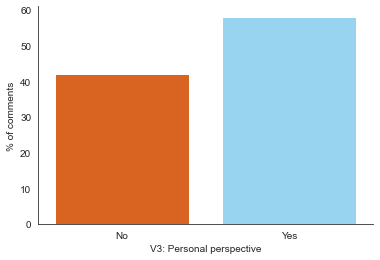

In [12]:
# Set style options for plot
sns.set_style('white') # Back ground

# Create plot and set labels (value_counts(normalize=True))
counts = df_V3['V3'].value_counts(normalize=True).mul(100).rename('count').reset_index().sort_values('index')

# Set colour palette
palette = {c: '#89DAFF' if c != 'No' else '#F75C03' for c in counts['index']}

# Create plot and set labels
sns.barplot(x='index', y='count', data=counts, order=counts['index'], palette=palette)
plt.ylabel('% of comments')
plt.xlabel('V3: Personal perspective')

# Remove right and top spines
sns.despine()

# Save and plot figure
plt.savefig('data/v3_personalperspective.png', dpi=1200)
plt.show()

# Prediction

## Train- and test-dataset

In [13]:
# Declare rng variable in order to get reproducible results across multiple examinations
rng = np.random.RandomState(0)

# Define X and y
X = list(proc_txt) # The descriptions we base our prediction on --> X
y = list(df['V3'].values) # The labels we want to predict --> Y
labels = ['No','Yes']

# Split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=rng)

print(len(X_train), len(X_test))

3250 813


## TF-IDF

In [14]:
# Call vectorizer
tfidf = TfidfVectorizer(tokenizer=lambda x:x,
                        preprocessor=lambda x:x) 

# Create the vocabulary
tfidf.fit(X_train)

# Vectorize textual data
X_train = tfidf.transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

C:\Users\Jo\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


## Set variables for GridSearchCV()

In [15]:
# Set cross-validation method as input for GridSearchCV()
cv_method = StratifiedKFold(n_splits=5)

## Logistic regression

### Train classifier

In [16]:
# Set parameters
param_grid_lr = {
    'C': [0.1, 1, 10, 100, 1000]
}

# Find best Logistic Regression classifier
lr_grid = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid_lr, verbose=3, cv=cv_method)

# Fit best model
lr_grid.fit(X_train, y_train)
print(lr_grid.best_estimator_)

# Predict marker for test dataset
y_pred_lr = lr_grid.predict(X_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .............................C=0.1;, score=0.872 total time=   0.9s
[CV 2/5] END .............................C=0.1;, score=0.860 total time=   1.1s
[CV 3/5] END .............................C=0.1;, score=0.849 total time=   1.0s
[CV 4/5] END .............................C=0.1;, score=0.869 total time=   1.0s
[CV 5/5] END .............................C=0.1;, score=0.865 total time=   1.1s
[CV 1/5] END ...............................C=1;, score=0.905 total time=   2.2s
[CV 2/5] END ...............................C=1;, score=0.914 total time=   2.1s
[CV 3/5] END ...............................C=1;, score=0.891 total time=   2.0s
[CV 4/5] END ...............................C=1;, score=0.905 total time=   2.1s
[CV 5/5] END ...............................C=1;, score=0.892 total time=   2.2s
[CV 1/5] END ..............................C=10;, score=0.915 total time=   4.2s
[CV 2/5] END ..............................C=10;,

C:\Users\Jo\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 1/5] END ............................C=1000;, score=0.902 total time=   5.6s
[CV 2/5] END ............................C=1000;, score=0.914 total time=   4.5s
[CV 3/5] END ............................C=1000;, score=0.894 total time=   3.4s
[CV 4/5] END ............................C=1000;, score=0.905 total time=   4.9s


C:\Users\Jo\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 5/5] END ............................C=1000;, score=0.905 total time=   5.6s
LogisticRegression(C=10)


In [17]:
# Print classification report
report = classification_report(y_test, y_pred_lr, 
                               target_names=labels,
                               output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
df_cm = pd.DataFrame(cm)
display(df_cm)

,precision,recall,f1-score,support
No,0.863636,0.890625,0.876923,320.000000
Yes,0.927536,0.908722,0.918033,493.000000
accuracy,0.901599,0.901599,0.901599,0.901599
macro avg,0.895586,0.899674,0.897478,813.000000
weighted avg,0.902385,0.901599,0.901852,813.000000


,0,1
0,285,35
1,45,448


### Interpretation

In [ ]:
# Get the Logistic Regression weights
vocabulary = tfidf.get_feature_names()
regression_coefficients = lr_grid.best_estimator_.coef_[0] # get the LR weights

# Put weights and words into a dataframe
vocab_coef_combined = list(zip(regression_coefficients, vocabulary)) # this combines two separate lists [1, 2], ['word1', 'word2'] into one list [[1, 'word1'], [2, 'word2']]
feature_importance = pd.DataFrame(vocab_coef_combined,
                      columns=['coef', 'word'])

In [31]:
coefficients = feature_importance.sort_values('coef', ascending=True).head(15)
coefficients = coefficients.append(feature_importance.sort_values('coef', ascending=True).tail(15))

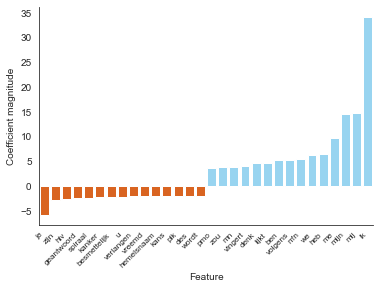

In [33]:
# Set style options for plot
sns.set_style('white') # Back ground

# Set colour palette
palette = {w: '#89DAFF' if c > 0 else '#F75C03' for c,w in coefficients.values}

# Create plot
ax = sns.barplot(x='word',y='coef',data=coefficients,palette=palette)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, size=8.2, ha='right')
plt.ylabel('Coefficient magnitude')
plt.xlabel('Feature')

# Remove right and top spines
sns.despine()

plt.savefig('data/coef.png', dpi=1200, bbox_inches='tight')
plt.show()

## SVM

In [ ]:
param_grid_svm = {'C': [0.1, 1, 10, 100]}
 
lsvc_grid = GridSearchCV(SVC(kernel='linear'), param_grid=param_grid_svm, verbose=3, cv=cv_method)

# Fit best model
lsvc_grid.fit(X_train, y_train)
print(lsvc_grid.best_estimator_)

# Predict marker for test dataset
y_pred_lsvc = lsvc_grid.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .............................C=0.1;, score=0.866 total time= 4.8min
[CV 2/5] END .............................C=0.1;, score=0.872 total time= 4.8min
[CV 3/5] END .............................C=0.1;, score=0.862 total time= 4.9min
[CV 4/5] END .............................C=0.1;, score=0.854 total time= 5.0min
[CV 5/5] END .............................C=0.1;, score=0.851 total time= 5.3min
[CV 1/5] END ...............................C=1;, score=0.909 total time= 3.7min
[CV 2/5] END ...............................C=1;, score=0.920 total time= 3.6min
[CV 3/5] END ...............................C=1;, score=0.906 total time= 3.7min
[CV 4/5] END ...............................C=1;, score=0.922 total time= 3.6min
[CV 5/5] END ...............................C=1;, score=0.915 total time= 3.6min
[CV 1/5] END ..............................C=10;, score=0.895 total time= 4.5min
[CV 2/5] END ..............................C=10;,

In [20]:
# Print classification report
report = classification_report(y_test, y_pred_lsvc, 
                               target_names=labels,
                               output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred_lsvc)
df_cm = pd.DataFrame(cm)
display(df_cm)

,precision,recall,f1-score,support
No,0.842566,0.903125,0.871795,320.000000
Yes,0.934043,0.890467,0.911734,493.000000
accuracy,0.895449,0.895449,0.895449,0.895449
macro avg,0.888304,0.896796,0.891765,813.000000
weighted avg,0.898037,0.895449,0.896014,813.000000


,0,1
0,289,31
1,54,439
